

 # 基于Darcy-Flow（达西流）的U-NO模型训练



 本教程展示如何在neuralop库自带的小型Darcy-Flow数据集上训练U型神经算子（U-NO）。

 U-NO架构结合了神经算子的**分辨率不变性**和U-Net的**多尺度特征提取**能力，

 通过跳跃连接和多分辨率处理捕捉数据中的局部和全局特征，特别适用于复杂的偏微分方程（PDE）求解问题。



In [1]:
# ============================ 1. 导入核心依赖库 ============================
# 导入PyTorch核心库，用于张量计算和模型构建
import torch
# 导入matplotlib用于结果可视化
import matplotlib.pyplot as plt
# 导入sys用于系统输出刷新
import sys
# 从neuralop库导入U-NO模型核心类
from neuralop.models import UNO
# 导入训练器类，封装了完整的训练循环逻辑
from neuralop import Trainer
# 导入AdamW优化器（带权重衰减的Adam）
from neuralop.training import AdamW
# 导入内置的Darcy-Flow数据集加载函数
from neuralop.data.datasets import load_darcy_flow_small
# 导入模型参数量统计工具
from neuralop.utils import count_model_params
# 导入损失函数：LpLoss（L2损失）和H1Loss（包含梯度的损失，更适合PDE问题）
from neuralop import LpLoss, H1Loss

# 设置计算设备：优先CPU（新手友好，无需GPU环境）
device = "cpu"


尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages
尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages




 ## 加载Darcy-Flow数据集

 Darcy-Flow（达西流）是描述多孔介质中流体流动的经典PDE问题，

 数据集包含输入（渗透率场）和输出（压力场）的配对数据。



In [2]:
# ============================ 2. 加载并预处理数据集 ============================
# 加载小型Darcy-Flow数据集，返回训练加载器、测试加载器列表、数据处理器
train_loader, test_loaders, data_processor = load_darcy_flow_small(
    n_train=1000,          # 训练集样本数量：1000个
    batch_size=32,         # 训练批次大小：每次迭代处理32个样本
    n_tests=[100, 50],     # 测试集样本数量：16x16分辨率100个，32x32分辨率50个
    test_resolutions=[16, 32],  # 测试集的两种空间分辨率
    test_batch_sizes=[32, 32],  # 测试集的批次大小
)


Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 




 ## 构建U-NO模型

 U-NO（U-shaped Neural Operator）是结合Neural Operator和U-Net的混合架构，

 核心参数控制网络的通道数、傅里叶模态数、分辨率缩放比例等关键特性。



In [3]:
# ============================ 3. 初始化U-NO模型 ============================
model = UNO(
    in_channels=1,                # 输入通道数：Darcy-Flow输入为单通道渗透率场
    out_channels=1,               # 输出通道数：Darcy-Flow输出为单通道压力场
    hidden_channels=64,           # 隐藏层基础通道数（网络宽度）
    projection_channels=64,       # 投影层通道数（用于特征维度转换）
    uno_out_channels=[32, 64, 64, 64, 32],  # U型结构各层输出通道数（下采样→上采样）
    uno_n_modes=[[8, 8], [8, 8], [4, 4], [8, 8], [8, 8]],  # 各层傅里叶模态数（控制频域捕捉能力）
    uno_scalings=[[1.0, 1.0], [0.5, 0.5], [1, 1], [2, 2], [1, 1]],  # 各层分辨率缩放比例
    # 下采样：0.5=分辨率减半；上采样：2=分辨率翻倍
    horizontal_skips_map=None,    # 水平跳跃连接映射（默认关闭）
    channel_mlp_skip="linear",    # 通道维度MLP的跳跃连接类型（线性映射）
    n_layers=5,                   # U型结构的总层数
)

# 将模型移动到指定计算设备（CPU/GPU）
model = model.to(device)

# 统计并打印模型总参数量（评估模型复杂度）
n_params = count_model_params(model)
print(f"\n模型总参数量：{n_params} 个。")
# 强制刷新系统输出，确保参数量信息即时显示
sys.stdout.flush()


fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'

模型总参数量：1405761 个。




 ## 配置优化器和学习率调度器

 使用AdamW优化器（带权重衰减）防止过拟合，

 余弦退火调度器动态调整学习率，提升训练稳定性。



In [4]:
# ============================ 4. 配置优化器和学习率调度器 ============================
# 初始化AdamW优化器
optimizer = AdamW(
    model.parameters(),  # 待优化的模型参数
    lr=8e-3,             # 初始学习率：8×10^-3
    weight_decay=1e-4    # 权重衰减系数（L2正则化，防止过拟合）
)

# 余弦退火学习率调度器：学习率随训练轮数按余弦曲线衰减
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,  # 关联的优化器
    T_max=30    # 余弦周期：30个epoch完成一次余弦衰减
)




 ## 设置损失函数

 训练使用H1Loss（包含函数值+梯度的损失，更贴合PDE的弱形式），

 评估同时使用H1Loss和L2Loss（仅函数值误差，更直观）。



In [5]:
# ============================ 5. 定义损失函数 ============================
# 定义L2损失（LpLoss，d=2维空间，p=2阶范数）
l2loss = LpLoss(d=2, p=2)
# 定义H1损失（包含L2损失 + 梯度的L2损失，d=2维空间）
h1loss = H1Loss(d=2)

# 训练损失：使用H1Loss（更适合PDE问题的损失函数）
train_loss = h1loss
# 评估损失字典：同时评估H1和L2损失，便于对比
eval_losses = {"h1": h1loss, "l2": l2loss}




 ## 打印训练配置信息

 输出模型、优化器、调度器、损失函数的核心配置，便于调试和记录。



In [6]:
# ============================ 6. 打印训练配置 ============================
print("\n### 模型配置已打印到 UNO_model_config.txt ###\n")
with open("UNO_model_config.txt", "w") as f:
    print(model, file=f)
print("\n### 优化器配置 ###\n", optimizer)
print("\n### 学习率调度器 ###\n", scheduler)
print("\n### 损失函数 ###")
print(f"\n * 训练损失: {train_loss}")
print(f"\n * 测试损失: {eval_losses}")
# 强制刷新输出
sys.stdout.flush()


### 模型配置已打印到 UNO_model_config.txt ###


### 优化器配置 ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### 学习率调度器 ###

### 损失函数 ###

 * 训练损失: <neuralop.losses.data_losses.H1Loss object at 0x0000029B3296B740>

 * 测试损失: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x0000029B3296B740>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x0000029B2FC1E630>}




 ## 创建训练器

 neuralop的Trainer类封装了完整的训练逻辑（前向传播、反向传播、评估、日志记录等），

 只需配置核心参数即可自动执行训练循环。



In [7]:
# ============================ 7. 初始化训练器 ============================
trainer = Trainer(
    model=model,                # 待训练的模型
    n_epochs=100,                # 总训练轮数：100个epoch（轻量化示例，实际应用需更多）
    device=device,              # 计算设备
    data_processor=data_processor,  # 数据处理器（负责数据的预处理/后处理）
    wandb_log=False,            # 关闭Weights & Biases日志（无需第三方日志工具）
    eval_interval=5,            # 评估间隔：每5个epoch在测试集上评估一次
    use_distributed=False,      # 关闭分布式训练（单CPU/GPU训练）
    verbose=True,               # 打印训练过程详细日志
)




 ## 训练U-NO模型

 调用训练器的train方法执行完整训练流程：

 1. 遍历训练集，执行前向传播计算损失

 2. 反向传播更新模型参数

 3. 按间隔在测试集上评估模型性能

 4. 学习率调度器按轮数调整学习率



In [8]:
# ============================ 8. 执行模型训练 ============================
trainer.train(
    train_loader=train_loader,  # 训练集数据加载器
    test_loaders=test_loaders,  # 测试集数据加载器列表
    optimizer=optimizer,        # 优化器
    scheduler=scheduler,        # 学习率调度器
    regularizer=False,          # 关闭额外正则化（已通过权重衰减实现）
    training_loss=train_loss,   # 训练损失函数
    eval_losses=eval_losses,    # 评估损失函数字典
)


Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].


c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1786: UserWarning: UNO.forward() received unexpected keyword arguments: ['y']. These arguments will be ignored.
  return forward_call(*args, **kwargs)
c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\training\trainer.py:536: UserWarning: H1Loss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  loss += training_loss(out, **sample)


Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=5.40, avg_loss=0.7596, train_err=23.7385


c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\training\trainer.py:581: UserWarning: LpLoss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  val_loss = loss(out, **sample)


Eval: 16_h1=0.4236, 16_l2=0.2696, 32_h1=0.5803, 32_l2=0.2809
[5] time=5.31, avg_loss=0.2312, train_err=7.2251
Eval: 16_h1=0.2402, 16_l2=0.1592, 32_h1=0.4415, 32_l2=0.2064
[10] time=5.63, avg_loss=0.1793, train_err=5.6030
Eval: 16_h1=0.2132, 16_l2=0.1275, 32_h1=0.4255, 32_l2=0.1810
[15] time=5.36, avg_loss=0.1701, train_err=5.3166
Eval: 16_h1=0.2635, 16_l2=0.1797, 32_h1=0.4216, 32_l2=0.2183
[20] time=5.47, avg_loss=0.1412, train_err=4.4124
Eval: 16_h1=0.2114, 16_l2=0.1203, 32_h1=0.3842, 32_l2=0.1537
[25] time=5.66, avg_loss=0.1055, train_err=3.2968
Eval: 16_h1=0.2039, 16_l2=0.1112, 32_h1=0.4058, 32_l2=0.1531
[30] time=5.50, avg_loss=0.0914, train_err=2.8573
Eval: 16_h1=0.1961, 16_l2=0.1048, 32_h1=0.3953, 32_l2=0.1505
[35] time=5.68, avg_loss=0.0941, train_err=2.9419
Eval: 16_h1=0.1989, 16_l2=0.1053, 32_h1=0.4017, 32_l2=0.1513
[40] time=5.22, avg_loss=0.0830, train_err=2.5936
Eval: 16_h1=0.2054, 16_l2=0.1086, 32_h1=0.4024, 32_l2=0.1591
[45] time=5.26, avg_loss=0.1421, train_err=4.4417
Ev

{'train_err': 1.6422702176496387,
 'avg_loss': 0.05255264696478844,
 'avg_lasso_loss': None,
 'epoch_train_time': 5.424890199999936}



 ## 可视化U-NO预测结果

 训练完成后，可视化模型在32x32分辨率测试集上的预测结果，

 对比输入、真实值、预测值，直观评估模型效果。

 注：本示例为轻量化演示，仅用少量数据和轮数训练，实际应用需更大数据集和更多训练轮数。



C:\Users\MR\AppData\Local\Temp\ipykernel_9684\633837128.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


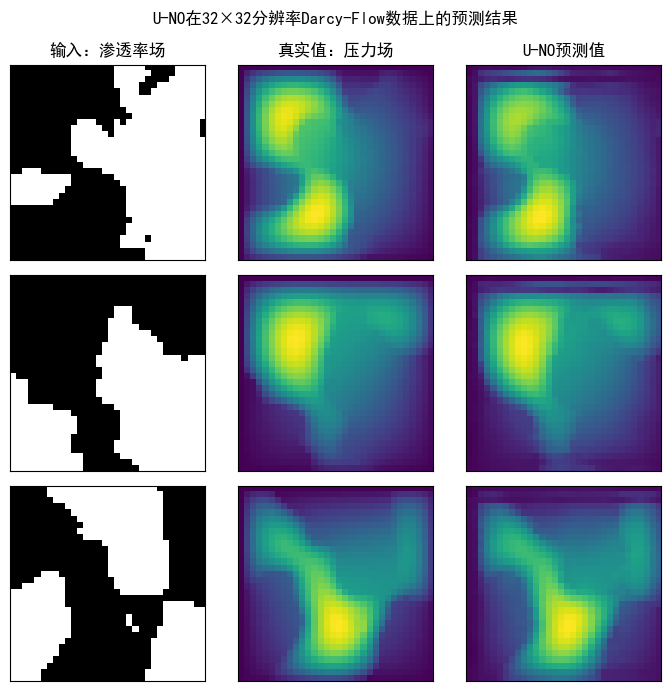

In [9]:
# ============================ 9. 可视化预测结果 ============================
# 获取32x32分辨率的测试集样本（test_loaders[32]对应32x32分辨率）
test_samples = test_loaders[32].dataset

plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

# 创建画布，设置尺寸为7x7英寸
fig = plt.figure(figsize=(7, 7))
# 可视化前3个测试样本
for index in range(3):
    # 获取第index个测试样本
    data = test_samples[index]
    # 对单个样本进行预处理（非批量模式）
    data = data_processor.preprocess(data, batched=False)
    # 输入数据：渗透率场（x）
    x = data["x"]
    # 真实标签：压力场（y）
    y = data["y"]
    # 模型预测：添加batch维度（模型要求输入为[batch, channels, H, W]），并移动到计算设备
    out = model(x.unsqueeze(0).to(device)).cpu()

    # 绘制输入x（渗透率场）
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    ax.imshow(x[0], cmap="gray")  # x.shape=[1, H, W]，取x[0]显示
    if index == 0:
        ax.set_title("输入：渗透率场")  # 仅第一个子图设置标题
    plt.xticks([], [])  # 隐藏x轴刻度
    plt.yticks([], [])  # 隐藏y轴刻度

    # 绘制真实值y（压力场）
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze())  # 挤压维度，仅保留H×W
    if index == 0:
        ax.set_title("真实值：压力场")
    plt.xticks([], [])
    plt.yticks([], [])

    # 绘制模型预测值
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    # 挤压维度+转换为numpy数组（用于绘图），detach()脱离计算图
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title("U-NO预测值")
    plt.xticks([], [])
    plt.yticks([], [])

# 设置总标题，y=0.98调整标题位置（避免遮挡子图）
fig.suptitle("U-NO在32×32分辨率Darcy-Flow数据上的预测结果", y=0.98)
# 自动调整子图间距，避免重叠
plt.tight_layout()
# 显示图像
fig.show()